<a href="https://colab.research.google.com/github/Ashrafalaghbari/oil-production-forecasting/blob/main/optimal_TCN_single_step.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%autosave 60

Autosaving every 60 seconds


In [ ]:
pip install keras-tcn --no-dependencies

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import os
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import itertools
import re
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense,Activation, Dropout
from keras.layers import LSTM, Conv1D
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import math 

In [ ]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [ ]:
# # check if GPU is utilized 
# device_name = tf.config.experimental.list_physical_devices()[-1][-1]
# if device_name != 'GPU':
#     raise SystemError('GPU device not found')
# print('Found GPU at: {}'.format(tf.test.gpu_device_name()))

In [3]:
# Select the best features
def select_features(df, target, correlation_type, threshold):
    if (threshold < -1 ) | (threshold > 1 ) :
            raise SystemError('correlation threshold is out of bounds')
    features = df.corr(correlation_type).loc[target].drop(target)
    best_features = features.where(abs(features) > threshold).dropna()
    df = pd.concat([df[target], df[best_features.index]], axis=1)
    return df

# convert series to supervised learning using a sliding  window approach
def series_to_supervised(data, columns, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('%s(t-%d)' % (columns[j], i)) for j in range(n_vars)]
        # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('%s(t)' % (columns[j])) for j in range(n_vars)]
        else:
            names += [('%s(t+%d)' % (columns[j], i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

# scale train and test data to new feature range[0, 1]
def scale(train, test):
	# fit scaler
	scaler = MinMaxScaler(feature_range=(0, 1))
	scaler = scaler.fit(train)
	# transform train
	train = train.reshape(train.shape[0], train.shape[1])
	train_scaled = scaler.transform(train)
	# transform test
	test = test.reshape(test.shape[0], test.shape[1])
	test_scaled = scaler.transform(test)
	return scaler, train_scaled, test_scaled


# inverse differencing
def inverse_difference(history, interval=1):
	return history[-len(test_scaled)-interval:-interval]

#Evaluation metrics
# compute RMSPE
def RMSPE(x,y):
	result=0
	for i in range(len(x)):
		result += ((x[i]-y[i])/x[i])**2
	result /= len(x)
	result = sqrt(result)
	result *= 100
	return result

# compute MAPE
def MAPE(x,y):
	result=0
	for i in range(len(x)):
		result += abs((x[i]-y[i])/x[i])
	result /= len(x)
	result *= 100
	return result

# compute wMAPE weighted absolute percentage error
def wMAPE(actual, predicted): 
    result_nom = 0
    result_deno = 0
    for i in range(len(actual)):
        result_nom +=  abs(actual[i] - predicted[i])
        result_deno +=  abs(actual[i]) 
    result = result_nom/result_deno
    return result *100

def SMAPE(actual, predicted): #Symmetric (adjusted) MEAN ABSOLUTE PERCENTAGE ERROR (SMAPE)
    result = 0
    for i in range(len(actual)):
        result += abs(actual[i] - predicted[i])/(abs(actual[i]) + abs(predicted[i]))
    result = 2 * result/ len(actual) 
    return result * 100

In [4]:
#load dataset
series = pd.read_csv('/content/drive/MyDrive/volve_production_data/model.csv', 
                     parse_dates=["DATEPRD"], index_col="DATEPRD")
days = pd.Series(range(len(series), 0, -1), index=series.index)
series.insert(0, 'days', days)
series['days1'] = series['days'].shift(-1)
series["AVG_CHOKE_SIZE_P1"] = series['AVG_CHOKE_SIZE_P'].shift(-1)
series["ON_STREAM_HRS1"] = series['ON_STREAM_HRS'].shift(-1)
series['days2'] = series['days'].shift(-2)
series["AVG_CHOKE_SIZE_P2"] = series['AVG_CHOKE_SIZE_P'].shift(-2)
series["ON_STREAM_HRS2"] = series['ON_STREAM_HRS'].shift(-2)

series['days3'] = series['days'].shift(-3)
series["AVG_CHOKE_SIZE_P3"] = series['AVG_CHOKE_SIZE_P'].shift(-3)
series["ON_STREAM_HRS3"] = series['ON_STREAM_HRS'].shift(-3)


series['interaction_effect_onNext_oil1'] = series["AVG_CHOKE_SIZE_P1"] * series["days1"] * series["ON_STREAM_HRS1"]
series['interaction_effect_onNext_oil2'] = series["AVG_CHOKE_SIZE_P2"] * series["days2"] * series["ON_STREAM_HRS2"]
series['interaction_effect_onNext_oil3'] = series["AVG_CHOKE_SIZE_P3"] * series["days3"] * series["ON_STREAM_HRS3"]
series.dropna(inplace=True)


# # # # select feature based on correlation
# # series = select_features(series, "BORE_OIL_VOL", "spearman", 0.2)
# # select features manually
series =series[['interaction_effect_onNext_oil1', 'interaction_effect_onNext_oil2', 'interaction_effect_onNext_oil3',
                "BORE_OIL_VOL",
                "ON_STREAM_HRS1","ON_STREAM_HRS2","ON_STREAM_HRS3", "AVG_CHOKE_SIZE_P1", "AVG_CHOKE_SIZE_P2", "AVG_CHOKE_SIZE_P3"
                ]] 
series.shape             

(1905, 10)

In [26]:
series = pd.read_csv('/content/drive/MyDrive/volve_production_data/model.csv', 
                     parse_dates=["DATEPRD"], index_col="DATEPRD")
series.columns

Index(['ON_STREAM_HRS', 'AVG_DOWNHOLE_PRESSURE', 'AVG_DOWNHOLE_TEMPERATURE',
       'AVG_CHOKE_SIZE_P', 'AVG_WHP_P', 'AVG_WHT_P', 'DP_CHOKE_SIZE',
       'BORE_OIL_VOL', 'BORE_GAS_VOL', 'BORE_WAT_VOL', 'F_4_ON_STREAM_HRS',
       'F_4_BORE_WI_VOL', 'F_5_ON_STREAM_HRS', 'F_5_BORE_WI_VOL'],
      dtype='object')

In [55]:
#load dataset
series = pd.read_csv('/content/drive/MyDrive/volve_production_data/model.csv', 
                     parse_dates=["DATEPRD"], index_col="DATEPRD")
days = pd.Series(range(len(series), 0, -1), index=series.index)
series.insert(0, 'days', days)
series['days1'] = series['days'].shift(-1)
series["AVG_CHOKE_SIZE_P1"] = series['AVG_CHOKE_SIZE_P'].shift(-1)
series["ON_STREAM_HRS1"] = series['ON_STREAM_HRS'].shift(-1)
series['days2'] = series['days'].shift(-2)
series["AVG_CHOKE_SIZE_P2"] = series['AVG_CHOKE_SIZE_P'].shift(-2)
series["ON_STREAM_HRS2"] = series['ON_STREAM_HRS'].shift(-2)

series['days3'] = series['days'].shift(-3)
series["AVG_CHOKE_SIZE_P3"] = series['AVG_CHOKE_SIZE_P'].shift(-3)
series["ON_STREAM_HRS3"] = series['ON_STREAM_HRS'].shift(-3)


series['interaction_effect_onNext_oil1'] = series["AVG_CHOKE_SIZE_P1"] *  series["ON_STREAM_HRS1"]
series['interaction_effect_onNext_oil2'] = series["AVG_CHOKE_SIZE_P2"] *  series["ON_STREAM_HRS2"]
series['interaction_effect_onNext_oil3'] = series["AVG_CHOKE_SIZE_P3"] *  series["ON_STREAM_HRS3"]
series.dropna(inplace=True)


# # # # select feature based on correlation
# # series = select_features(series, "BORE_OIL_VOL", "spearman", 0.2)
# # select features manually
series =series[['interaction_effect_onNext_oil1', 'interaction_effect_onNext_oil2', 'interaction_effect_onNext_oil3',
                 "days",
                "ON_STREAM_HRS1","ON_STREAM_HRS2","ON_STREAM_HRS3", "AVG_CHOKE_SIZE_P1", "AVG_CHOKE_SIZE_P2", "AVG_CHOKE_SIZE_P3",

                'AVG_DOWNHOLE_PRESSURE', 'AVG_DOWNHOLE_TEMPERATURE',
        'AVG_WHP_P', 'AVG_WHT_P',
        'BORE_GAS_VOL', 'BORE_WAT_VOL', 
       #'F_4_BORE_WI_VOL',  'F_5_BORE_WI_VOL',
       "BORE_OIL_VOL"

                ]] 
series.shape             

(1905, 17)

In [56]:
col = ["ON_STREAM_HRS1","ON_STREAM_HRS2","ON_STREAM_HRS3", "AVG_CHOKE_SIZE_P1", "AVG_CHOKE_SIZE_P2", "AVG_CHOKE_SIZE_P3"]
for i in col:
    if i not in ["AVG_CHOKE_SIZE_P1", "AVG_CHOKE_SIZE_P2", "AVG_CHOKE_SIZE_P3"]:
        series[f"{i}cut"] = pd.cut(series[i], bins= [0,5,10,15,20,24])
    else: 
        series[f"{i}cut"] = pd.cut(series[i], bins= [0,10,20,30,40,50,60,70,80,90, 100])

In [8]:
series.shape

(1905, 49)

In [57]:
data = ['ON_STREAM_HRS1cut',
       'ON_STREAM_HRS2cut', 'ON_STREAM_HRS3cut', 'AVG_CHOKE_SIZE_P1cut',
       'AVG_CHOKE_SIZE_P2cut', 'AVG_CHOKE_SIZE_P3cut']
for i in data:
    df = pd.get_dummies(series[i], prefix =i)
    series.drop([i],axis=1, inplace=True)
    series = pd.concat([series, df], axis=1)

In [58]:
series.drop(["ON_STREAM_HRS1","ON_STREAM_HRS2","ON_STREAM_HRS3", "AVG_CHOKE_SIZE_P1", "AVG_CHOKE_SIZE_P2", "AVG_CHOKE_SIZE_P3"],
            axis=1, inplace=True)

In [59]:
# Create a new directory in My Drive
directory = '/content/drive/My Drive/my_trained_models'
if not os.path.exists(directory):
    os.makedirs(directory)

In [98]:
# # # convert series to stationary 
series_diff = series.copy()
diff_order = 1
series_diff['BORE_OIL_VOL'] = series_diff['BORE_OIL_VOL'].diff(diff_order)

# Define window size and number of the steps ahead for forecasting
window_size = 4
steps_ahead = 3

# # convert the stationary series to supervise learning
series_supervised = series_to_supervised(series_diff, series_diff.columns, n_in= window_size, n_out= steps_ahead, dropnan=True)   

# drop columns we don't want to predict
pattern = re.compile(r"(t-)|^BORE_OIL_VOL.*")

# Extract the column names that match the pattern
matching_columns = [col for col in series_supervised.columns if re.search(pattern, col)]
series_supervised = series_supervised[matching_columns]

In [99]:
# # split into train and test sets
n_features = int((len(series_supervised.columns) -steps_ahead)/window_size)
series_supervised = series_supervised.values
train_size = int(series_supervised.shape[0] * 0.8)
test_size = series_supervised.shape[0] - train_size
train, test = series_supervised[0:train_size], series_supervised[train_size:]
print("train.shape:",train.shape, "test.shape:",test.shape)

# scale  the data to a feature range(0,1)
scaler, train_scaled, test_scaled = scale(train, test)
print('train_scaled.shape:',train_scaled.shape, "test_scaled.shape:",test_scaled.shape)

# # reshape input to be 3D [samples, window_size, features]
train_X, train_y = train_scaled[:, 0:-steps_ahead], train_scaled[:, -steps_ahead:]
train_X = train_X.reshape(train_X.shape[0], window_size, n_features)
test_X, test_y = test_scaled[:, 0:-steps_ahead], test_scaled[:, -steps_ahead:]
test_X = test_X.reshape(test_X.shape[0], window_size, n_features )
print("train_X.shape:",train_X.shape, "train_y.shape:",train_y.shape,
        "test_X.shape:", test_X.shape,"test_y.shape:",test_y.shape)

train.shape: (1518, 227) test.shape: (380, 227)
train_scaled.shape: (1518, 227) test_scaled.shape: (380, 227)
train_X.shape: (1518, 4, 56) train_y.shape: (1518, 3) test_X.shape: (380, 4, 56) test_y.shape: (380, 3)


In [ ]:
#grid search 
def get_hyper_param(n_epochs, num_hidden_layers, num_neurons, batch_size, window_size):
    """ 
    This is a grid search function that generates all possible comibinations
    from the search space 

    Args:
    n_epochs: number of epochs
    num_hidden_layers: number of hidden layers
    num_neurons: number of neurons same for both input and hidden layers 
    batch_size: number of batch size 
    window_size: historical timesteps in the sliding window
    
    """
    hyper_param = []
    for current_params in itertools.product(n_epochs, num_hidden_layers, num_neurons, batch_size, window_size):
        hyper_param.append(list(current_params))
    return hyper_param

# Seacrh space
n_epochs = [500]
num_hidden_layers = [1, 2]
num_neurons = [4, 8, 16, 32, 64]
batch_size = [2, 4]
window_size = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

hyper_param = get_hyper_param(n_epochs, num_hidden_layers, num_neurons, batch_size, window_size)
len(hyper_param)# print the number of combinations


220

In [ ]:
#hyperparamter tuning
def fit_lstm(steps_ahead = 3):
    
        # Create a new directory in My Drive
    directory = '/content/drive/My Drive/my_trained_models'
    if not os.path.exists(directory):
        os.makedirs(directory)

    # setting the session configurations for reproducibility.
    os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"  
    os.environ["CUDA_VISIBLE_DEVICES"] = ""
    os.environ['PYTHONHASHSEED'] = '0'
    np.random.seed(42)
    np.random.seed(12345)
    session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                                            inter_op_parallelism_threads=1)
    from keras import backend as K
    tf.random.set_seed(1234)
    sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), 
                                config=session_conf)
    K.set_session(sess)
  



    min_val_loss = math.inf 
    for n_epochs, num_hidden_layers, num_neurons, batch_size, window_size in hyper_param:
        print('n_epochs', n_epochs, 'num_hidden_layers', num_hidden_layers, 'num_neurons',
              num_neurons, "batch_size", batch_size, 'window_size', window_size)
        combinations = [n_epochs, num_hidden_layers, num_neurons, batch_size, window_size]

        #feature engineering
        # # convert the stationary series to supervise learning
        series_supervised = series_to_supervised(series_diff, series_diff.columns, n_in= window_size, n_out= steps_ahead, dropnan=True)   

        # drop columns we don't want to predict
        pattern = re.compile(r"(t-)|^BORE_OIL_VOL.*")
        # Extract the column names that match the pattern
        matching_columns = [col for col in series_supervised.columns if re.search(pattern, col)]
        series_supervised = series_supervised[matching_columns]

        # # split into train and test sets
        series_supervised = series_supervised.values
        train_size = int(series_supervised.shape[0] * 0.8)
        test_size = series_supervised.shape[0] - train_size
        train, test = series_supervised[0:train_size], series_supervised[train_size:]
        print("train.shape:",train.shape, "test.shape:",test.shape)

        # scale  the data to a feature range(0,1)
        scaler, train_scaled, test_scaled = scale(train, test)
        print('train_scaled.shape:',train_scaled.shape, "test_scaled.shape:",test_scaled.shape)

        # reshape input to be 3D [samples, window_size, features]
        n_features = len(series.columns)
        train_X, train_y = train_scaled[:, 0:-steps_ahead], train_scaled[:, -steps_ahead:]
        train_X = train_X.reshape(train_X.shape[0], window_size, n_features)
        test_X, test_y = test_scaled[:, 0:-steps_ahead], test_scaled[:, -steps_ahead:]
        test_X = test_X.reshape(test_X.shape[0], window_size, n_features )
        print("train_X.shape:",train_X.shape, "train_y.shape:",train_y.shape,
              "test_X.shape:", test_X.shape,"test_y.shape:",test_y.shape)
        
        # instantiate the LSTM model
        model = Sequential()

        if num_hidden_layers != 1:
  
            for num in range(num_hidden_layers-1):
                model.add(LSTM(num_neurons, input_shape=(window_size, n_features), return_sequences=True))
            model.add(LSTM(num_neurons))

        else:
            model.add(LSTM(num_neurons, input_shape=(window_size, n_features)))
        model.add(Dense(steps_ahead)) # output layer
        model.compile(loss='mean_squared_error',
                    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4))

        
        #prevent overfitting
        early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=2,
                                restore_best_weights=True, mode='min')
        
        # save the best weights
        mcp_save = ModelCheckpoint(os.path.join(directory, f'{combinations}_weights.hdf5'),
                            save_best_only=True,
                            monitor='val_loss', mode='min') 
        # fit model
        lstm_model = model.fit(train_X, train_y, epochs=n_epochs,
                            callbacks=[early_stopping, mcp_save],
                            batch_size=batch_size,
                            validation_data=(test_X, test_y), verbose=2, shuffle=False)
        
        # Save the model  in HDF5 foramt with a filename that includes the hyperparamters
        model.save(os.path.join(directory, f'{combinations}_model.h5'))
        # Load the best weights
        model.load_weights(os.path.join(directory, f'{combinations}_weights.hdf5'))
        current_val_loss = model.evaluate(test_X, test_y, verbose=0) #lstm_model.history['val_loss'][-1]
        if current_val_loss < min_val_loss:
            min_val_loss = current_val_loss
            best_params = [n_epochs,  num_hidden_layers, num_neurons, batch_size, window_size]

        
    print('final best params',"n_epochs:",best_params[0],"num_hidden_layers:",
          best_params[1], "num_neurons:", best_params[2], "batch_size:", best_params[3],
          "window_size:",best_params[4]) 
    return {"best_params": str(best_params) , "MSE": min_val_loss}#, lstm_model

In [ ]:
# # run the model and repeat the evaluation to reduce the certainty asscoicated with the random initialization of model weights
# def run_model(n_repeats = 1):
#     scores = [fit_lstm_random() for _ in range(n_repeats)]
#     result = pd.DataFrame(scores)
#     result = result.groupby("best_params").mean()
#     return result

In [ ]:
fit_lstm()

Streaming output truncated to the last 5000 lines.
380/380 - 1s - loss: 0.0013 - val_loss: 8.1495e-05 - 889ms/epoch - 2ms/step
Epoch 172/500
380/380 - 1s - loss: 0.0013 - val_loss: 8.1203e-05 - 909ms/epoch - 2ms/step
Epoch 173/500
380/380 - 1s - loss: 0.0013 - val_loss: 8.0918e-05 - 870ms/epoch - 2ms/step
Epoch 174/500
380/380 - 1s - loss: 0.0013 - val_loss: 8.0642e-05 - 879ms/epoch - 2ms/step
Epoch 175/500
380/380 - 1s - loss: 0.0012 - val_loss: 8.0374e-05 - 895ms/epoch - 2ms/step
Epoch 176/500
380/380 - 1s - loss: 0.0012 - val_loss: 8.0114e-05 - 872ms/epoch - 2ms/step
Epoch 177/500
380/380 - 1s - loss: 0.0012 - val_loss: 7.9863e-05 - 886ms/epoch - 2ms/step
Epoch 178/500
380/380 - 1s - loss: 0.0012 - val_loss: 7.9619e-05 - 886ms/epoch - 2ms/step
Epoch 179/500
380/380 - 1s - loss: 0.0012 - val_loss: 7.9383e-05 - 899ms/epoch - 2ms/step
Epoch 180/500
380/380 - 1s - loss: 0.0012 - val_loss: 7.9154e-05 - 888ms/epoch - 2ms/step
Epoch 181/500
380/380 - 1s - loss: 0.0012 - val_loss: 7.8933e-0

In [ ]:
n_epochs 500 num_hidden_layers 1 num_neurons 4 batch_size 4 window_size 7

In [13]:
from keras.layers import Input, Add, Reshape, BatchNormalization, Concatenate
from keras.models import Model

In [68]:
from tcn import TCN

In [ ]:
# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"  
# os.environ["CUDA_VISIBLE_DEVICES"] = ""
# os.environ['PYTHONHASHSEED'] = '0'
# np.random.seed(42)
# np.random.seed(12345)
# session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
#                                         inter_op_parallelism_threads=1)
# from keras import backend as K
# tf.random.set_seed(1234)
# sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), 
#                             config=session_conf)
# K.set_session(sess)

# fit the model
neurons=65# 22


input_tensor=Input(shape=(window_size, n_features))

# conv1 = Conv1D(filters = 16, kernel_size=1, dilation_rate=1, padding='same')(input_tensor)

# conv2 = Conv1D(filters = 5, kernel_size=1, dilation_rate=1, padding='same')(conv1)


# conv3 = Conv1D(filters = 20, kernel_size=4, dilation_rate=1, padding='causal')(conv2)
# tcn1 = TCN(input_shape=(window_size, n_features), kernel_size = 14,
#             nb_filters=46, return_sequences=True, dilations=[1, 1])(input_tensor)


lstm_output = LSTM(neurons, activation="tanh")(input_tensor)

# Create the concatenate layer
# concatenate_output = Concatenate()([conv3, lstm_output])




outputs = Dense(steps_ahead)(lstm_output) # output layer
model = Model(input_tensor, outputs)
model.compile(loss='mean_squared_error',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001))
early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=2,
                                restore_best_weights=True, mode='min')
# save the best weights if training is interrupted
mcp_save = ModelCheckpoint(os.path.join(directory, 'mdl_wts.hdf5'),
                            save_best_only=True,
                            monitor='val_loss', mode='min') 



# Set the initial and total number of epochs
initial_epoch = 1
n_epochs = 700
loss_tracking = list()


# Run the training loop
for epoch in range(initial_epoch , n_epochs+1):
    print(f'Epoch {epoch}/{n_epochs}')
    # Train the model for one epoch
    history = model.fit(train_X, train_y,#callbacks=[early_stopping, mcp_save],
                    epochs=1, batch_size=4, validation_data=(test_X, test_y),
                     verbose=2,
                     shuffle=False)
    # to find for which epoch each loss belongs
    validation_loss= model.evaluate(test_X, test_y, verbose=0)
    loss_tracking.append(validation_loss)
    # Save the model every 10 epochs
    if epoch % 100 == 0:
        # Save the model  in HDF5 foramt with a filename that includes the epoch number
        #model.save(f'model_{epoch}Eps.h5')
        model.save(os.path.join(directory, f'model_{epoch}Eps.h5'))

Epoch 1/700
380/380 - 5s - loss: 0.0395 - val_loss: 0.0022 - 5s/epoch - 13ms/step
Epoch 2/700
380/380 - 2s - loss: 0.0108 - val_loss: 0.0012 - 2s/epoch - 5ms/step


In [15]:
pip install keras-tcn --no-dependencies

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [17]:
from tcn import TCN

In [18]:


# conv1 = Conv1D(filters = 46, kernel_size=1, dilation_rate=1, padding='same')(input_tensor)


# conv2 = Conv1D(filters = 25, kernel_size=1, dilation_rate=1, padding='same')(conv1)


# conv3 = Conv1D(filters = 46, kernel_size=1, dilation_rate=1, padding='same')(conv2)
model = Sequential([
    model.add(Conv1D(filters = 146, kernel_size=1, dilation_rate=1, padding='same')),
    model.add(Conv1D(filters = 125, kernel_size=1, dilation_rate=1, padding='same')),
    model.add(Conv1D(filters = 110, kernel_size=1, dilation_rate=1, padding='same')),
    model.add(Conv1D(filters = 146, kernel_size=4, dilation_rate=16, padding='causal')),
    LSTM(64),
    Dense(3)
])

# model.add(Conv1D(filters = 46, kernel_size=1, dilation_rate=1, padding='same'))
# model.add(Conv1D(filters = 25, kernel_size=1, dilation_rate=1, padding='same'))
# model.add(Conv1D(filters = 10, kernel_size=1, dilation_rate=1, padding='same'))
# model.add(Conv1D(filters = 46, kernel_size=2, dilation_rate=8, padding='causal'))
# model.add(Conv1D(filters = 46, kernel_size=4, dilation_rate=16, padding='causal'))

# conv4 = Conv1D(filters = 10, kernel_size=1, dilation_rate=1, padding='same')(conv3)
# conv5 = Conv1D(filters = 10, kernel_size=1, dilation_rate=1, padding='same')(conv4)


# lstm_output = LSTM(neurons, activation="tanh")(conv3)
 
# outputs = Dense(steps_ahead)(lstm_output) # output layer
# model = Model(input_tensor, outputs)
# model.add(Dense(steps_ahead))

# Define the TCN layers
# model.add(TCN(nb_filters=46, kernel_size=1, dilations=[1,1,1], nb_stacks=3, input_shape =(window_size, n_features),
#           padding='same',# use_skip_connections=True,
#            #return_sequences=True,
#           activation='relu'#, kernel_initializer='he_normal'#,dropout_rate=0.1
#           ))
# model.add(LSTM(65))
# output layer
model.compile(loss='mean_squared_error',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001))


# Set the initial and total number of epochs
initial_epoch = 1
n_epochs = 500
loss_tracking = list()

history = model.fit(train_X, train_y,
                    epochs=500, batch_size=4, validation_data=(test_X, test_y),
                     verbose=2,
                     shuffle=False)




AttributeError: ignored

In [68]:
model.layers[0].output

<KerasTensor: shape=(None, 4, 46) dtype=float32 (created by layer 'conv1d_4')>

In [99]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"  
os.environ["CUDA_VISIBLE_DEVICES"] = ""
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(42)
np.random.seed(12345)
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                                        inter_op_parallelism_threads=1)
from keras import backend as K
tf.random.set_seed(1234)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), 
                            config=session_conf)
K.set_session(sess)

model = keras.models.Sequential([
    TCN(input_shape=(window_size, n_features), nb_filters=256, return_sequences=True, dilations=[1, 2, 4, 8, 16, 32]),
    keras.layers.Dense(steps_ahead)
    ])


model.compile(loss='mean_squared_error',
              optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4))

early_stopping = EarlyStopping(monitor='loss', patience=10, verbose=2,
                                restore_best_weights=True, mode='min')
# save the best weights if training is interrupted
mcp_save = ModelCheckpoint(os.path.join(directory, 'mdl_wts.hdf5'),
                            save_best_only=True,
                            monitor='val_loss', mode='min') 


# Set the initial and total number of epochs
initial_epoch = 1
n_epochs = 700
loss_tracking = list()

# Run the training loop
for epoch in range(initial_epoch , n_epochs+1):
    print(f'Epoch {epoch}/{n_epochs}')
    # Train the model for one epoch
    history = model.fit(train_X, train_y, callbacks=[early_stopping, mcp_save],
                    epochs=1, batch_size=4, validation_data=(test_X, test_y),
                     verbose=2,
                     shuffle=False)
    # to find for which epoch each loss belongs
    validation_loss= model.evaluate(test_X, test_y, verbose=0)
    loss_tracking.append(validation_loss)
    # Save the model every 10 epochs
    if epoch % 100 == 0:
        # Save the model  in HDF5 foramt with a filename that includes the epoch number
        #model.save(f'model_{epoch}Eps.h5')
        model.save(os.path.join(directory, f'model_{epoch}Eps.h5'))

NameError: ignored

In [ ]:
from tcn import TCN
from keras.layers import Input
from keras.models import Model
import keras

In [ ]:
input_tensor

<KerasTensor: shape=(None, 4, 4) dtype=float32 (created by layer 'input_4')>

In [ ]:
#  best tcn architecture is the one used in the papaer

In [ ]:
# load the trained saved model
model_saved = tf.keras.models.load_model('/content/drive/MyDrive/my_trained_models/[500, 1, 4, 2, 2]_model.h5')
# Load the best weights
model_saved.load_weights('/content/drive/MyDrive/my_trained_models/[500, 1, 4, 2, 2]_weights.hdf5')
#print the loss of the best weights
model_saved.evaluate(test_X, test_y, verbose=0)

In [ ]:
score = model.evaluate(test_X, test_y, verbose=0)
best_epoch = loss_tracking.index(score) + 1
# validation loss and corresponding epoch for the saved model
print(f'Epoch:{best_epoch}\nValidation loss: {score}') 

Epoch:82
Validation loss: 6.0132886574137956e-05


In [ ]:
# # continue if training is interrupted 
# model.compile(loss='mean_squared_error',
#               optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5))
# early_stopping = EarlyStopping(monitor='loss', patience=10, verbose=2,
#                                 restore_best_weights=True, mode='min')
# # save the best weights if training is interrupted
# mcp_save = ModelCheckpoint(os.path.join(directory, 'mdl_wts.hdf5'),
#                             save_best_only=True,
#                             monitor='val_loss', mode='min') 
# reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1, min_delta=1e-4, mode='min')

# # Set the initial and total number of epochs
# initial_epoch = 1
# n_epochs = 2000

# # Run the training loop
# for epoch in range(initial_epoch , n_epochs+1):
#     print(f'Epoch {epoch}/{n_epochs}')
#     # Train the model for one epoch
#     history = model.fit(train_X, train_y, callbacks=[early_stopping, mcp_save, reduce_lr_loss],
#                     epochs=1, batch_size=2, validation_data=(test_X, test_y),
#                      verbose=2,
#                      shuffle=False)
#     # to find for which epoch each loss belongs
#     validation_loss= model.evaluate(test_X, test_y, verbose=0)
#     loss_tracking.append(validation_loss)
#     # Save the model every 10 epochs
#     if epoch % 50 == 0:
#         # Save the model  in HDF5 foramt with a filename that includes the epoch number
#         #model.save(f'model_{epoch}Eps.h5')
#         model.save(os.path.join(directory, f'model_{epoch}Eps.h5'))

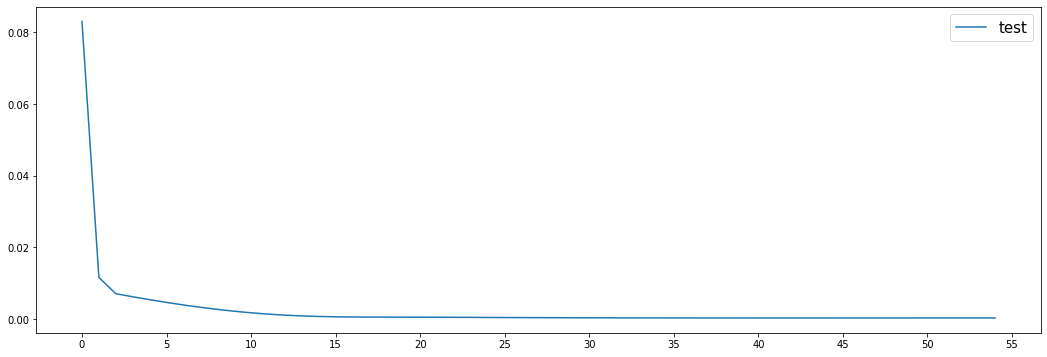

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(18,6)) 
ax.xaxis.set_major_locator(plt.MultipleLocator(5))
#plt.plot(history.history['loss'], label='train')
plt.plot(loss_tracking, label='test')
plt.legend(fontsize=15)
plt.show()

**MinMax Scaler equation**
$$x' = \frac{(x - min)}{(max - min)} \times (new\ max\ value - new\ min\  value) + new\ min\ value$$<br/>


$$x = \frac{(max - min)\times (new\ min\ value + x') + (new\ max\ value - new\ min\ value)\times min}{new\ max\ value - new\ min\ value}$$

Where:

$x$ is the inverse scaled value
$x'$ is the scaled value
$min$ is the minimum value of the original data
$max$ is the maximum value of the original data.<br/>
$new\ max\ value$ and $new\ min\ value$ is the new range that we want to scale the data to. For example: $(1,0)\ or\ (1,-1)$

In [ ]:
# make a prediction 
# select the number of obersvtions for prediction
n_obs = len(test)
yhat = model.predict(test_X[-n_obs:], verbose=1)


# invert scaling 
scaled_y = pd.DataFrame(test_y)
scaled_yhat = pd.DataFrame(yhat) ## ravel () converting into 1D array
#obtain the min and max from the training set
unscaled_train = pd.DataFrame(series_supervised[:len(train)])
#new feature range
new_max_value = 1 
new_min_value= 0
feature_range = new_max_value - new_min_value

def transform_column(column):
    min_value = min(unscaled_train.iloc[:, -steps_ahead + column.name])
    max_value = max(unscaled_train.iloc[:, -steps_ahead + column.name])
    return ((max_value - min_value) * (new_min_value + column) + (feature_range  * min_value)) / feature_range 
    
# invert scaling for actual
inv_scale_y = scaled_y.apply(transform_column, axis=0)
inv_scale_y = inv_scale_y.values
# invert scaling for forecast
inv_scale_yhat = scaled_yhat.apply(transform_column, axis=0)
inv_scale_yhat = inv_scale_yhat.values

12/12 [==============================] - 0s 2ms/step


In [ ]:
pd.DataFrame(inv_scale_y)

,0
0,3718.221536
1,3741.556734
2,3364.042301
3,3333.536720
4,3312.214262
...,...
375,1659.440731
376,1662.711432
377,1707.494884
378,1725.420844


In [ ]:
# Invert the Differencing for actual 
df = pd.DataFrame(series.iloc[-len(test)-steps_ahead:,-1])
n_vars = df.shape[1]
columns = df.columns
cols, names = list(), list()
for i in range(0, steps_ahead):
    cols.append(df.shift(-i))
    if i == 0:
        names += [('%s(t)' % (columns[j])) for j in range(n_vars)]
    else:
        names += [('%s(t+%d)' % (columns[j], i)) for j in range(n_vars)]
# put it all together
agg = pd.concat(cols, axis=1)
agg.columns = names
agg.dropna(inplace=True)
agg = agg.iloc[:-1]
#drop all the variables that we don't want to predict
#agg.drop(columns=vars_to_drop, inplace=True)
agg = agg.to_numpy()
inv_y = np.add(inv_scale_y,agg)

* To invert the differencing of time series for multistep prediction:<br/>
The equation is given by $$
\hat x_{t+h|t}=x_t+(\widehat{\Delta x_{t+1}}+\dots+\widehat{\Delta x_{t+h}}).
$$ <br/>
where: <br/>
$\hat x_{t+h|t}$ is the predicted value of the time series x at time $t$+h, given the value of the time series at time $t$.<br/>
$x_t$ is the value of the time series $x$ at time t.<br/>
${\Delta x_{t+1}}$ is the difference between the value of the time series $x$ at time $t+1$ and the value of the time series at time t.<br/>
${\Delta x_{t+2}}$ is the difference between the value of the time series $x$ at time $t+2$ and the value of the time series at time $t+1$.<br/>
${\Delta x_{t+h}}$ is the difference between the value of the time series $x$ at time $t+h$ and the value of the time series at time $t+h-1$.

In [ ]:
# Invert the Differencing for forecast
# to invert the diffrenced predicted values,the the predicted differenced value is added
# to previous predicted diffenced values and last available observation in test set(Xt) as explained above
originalSeries_supervised = series_to_supervised(series, series.columns, n_in=window_size, n_out=steps_ahead, dropnan=True)
current_timestep = 1
originalSeries_xt = originalSeries_supervised[['BORE_OIL_VOL(t)','BORE_OIL_VOL(t+1)']]
# A predicted value at any given step ahead is a result of the previous cumulative differnced predicted values and current time step
col = []
inv_yhat_cum = np.cumsum(inv_scale_yhat, axis=1)

for i in range(n_obs):
    #.ravel() flattens the series into a one-dimensional array
    inverted_diff_yhat = originalSeries_xt[-n_obs:].values[i] + inv_yhat_cum[i]
    col.append(inverted_diff_yhat)
col = pd.DataFrame(col)
inv_yhat = col.values # convert df to NumpyArray

In [ ]:
sqrt(mean_squared_error(inv_scale_y, inv_scale_yhat))

241.86829147086527

In [ ]:
r2_score(inv_scale_y, inv_scale_yhat)

0.8927672890049398

In [ ]:
# Performance evaluation
rmse_test, RMSPE_test, MAE_test, MAPE_test, r2_test, wMAPE_test, SMAPE_test  = [], [], [], [], [], [], []
# calculate the score for each day

for i in range(test_y.shape[1]):
    result_rmse = sqrt(mean_squared_error(inv_y[:,i], inv_yhat[:,i]))
    result_RMSPE = RMSPE(inv_y[:,i], inv_yhat[:,i])
    result_MAE = mean_absolute_error(inv_y[:,i], inv_yhat[:,i])
    result_MAPE = MAPE(inv_y[:,i], inv_yhat[:,i])
    result_r2 = r2_score(inv_y[:,i], inv_yhat[:,i])
    result_wMAPE = wMAPE(inv_y[:,i], inv_yhat[:,i])
    result_SMAPE = SMAPE(inv_y[:,i], inv_yhat[:,i])

    rmse_test.append(result_rmse)
    RMSPE_test.append(result_RMSPE)
    MAE_test.append(result_MAE)
    MAPE_test.append(result_MAPE)
    r2_test.append(result_r2)
    wMAPE_test.append(result_wMAPE)
    SMAPE_test.append(result_SMAPE)
    
## calculate overall score
print("The Average scores for the vector output {} steps ahead:\n".format(steps_ahead))
print('Test RMSE: %.5f' % np.mean(rmse_test))
#print('Test RMSPE: %.5f' % np.mean(RMSPE_test)) because of that the denominator (actual) has some zero values
print('Test MAE: %.5f' % np.mean(MAE_test))
#print('Test MAPE: %.5f' % np.mean(MAPE_test)) #because of that the denominator (actual) has some zero values
print('Test r2: %.5f' % np.mean(r2_test))
print('Test wMAPE: %.5f ' % np.mean(wMAPE_test))
print('Test SMAPE: %.5f ' % np.mean(SMAPE_test))

The Average scores for the vector output 2 steps ahead:

Test RMSE: 517.58664
Test MAE: 304.76658
Test r2: 0.45559
Test wMAPE: 13.34431 
Test SMAPE: 16.53452 


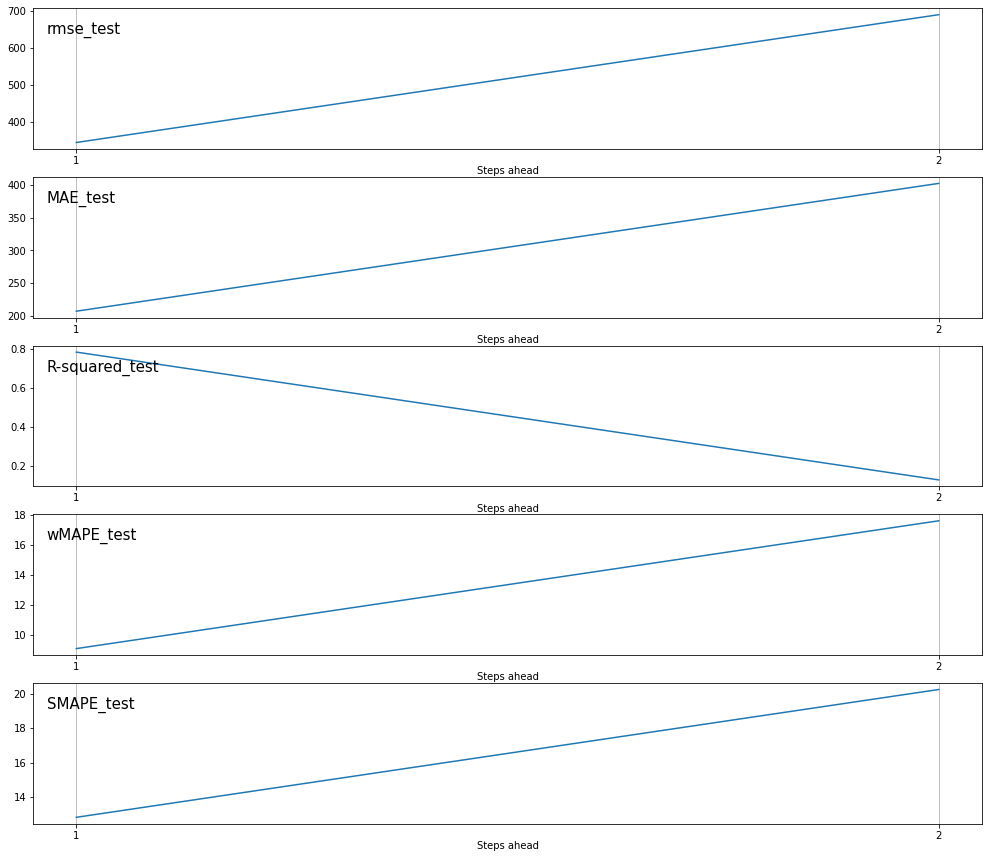

In [ ]:
# plot the scores for each time step of the multi-step forecast
scores = pd.DataFrame({"rmse_test":rmse_test, "MAE_test":MAE_test, "R-squared_test":r2_test, "wMAPE_test":wMAPE_test, "SMAPE_test":SMAPE_test})

# Reset the index, keeping the old index as a column
scores = scores.reset_index(drop=False)

# Set the 'index' column as the new index
scores.index = scores['index'] + 1

# Drop the old 'index' column
scores = scores.drop(columns='index')

data = scores.columns

# Creating figure with two rows and one column
fig, axs = plt.subplots(nrows=len(data), figsize=(17, 15))

axs = axs.ravel()

for id, column in enumerate(data):
    # Set the x-axis limits
    #axs[id].set_xlim(xmin=1, xmax= steps_ahead)
    #print the name of the test on plot
    axs[id].plot(scores[column])
    # Add a title to the x-axis
    axs[id].set_xlabel('Steps ahead',fontsize=10, labelpad=0.1)
    axs[id].grid(True)
    # Remove the horizontal grid lines
    axs[id].grid(which='both', axis='y')
    axs[id].xaxis.set_major_locator(plt.MultipleLocator(1))
    axs[id].legend([column], loc='upper left', fontsize=15, handlelength=0, handletextpad=0, frameon=False)
    
plt.show()

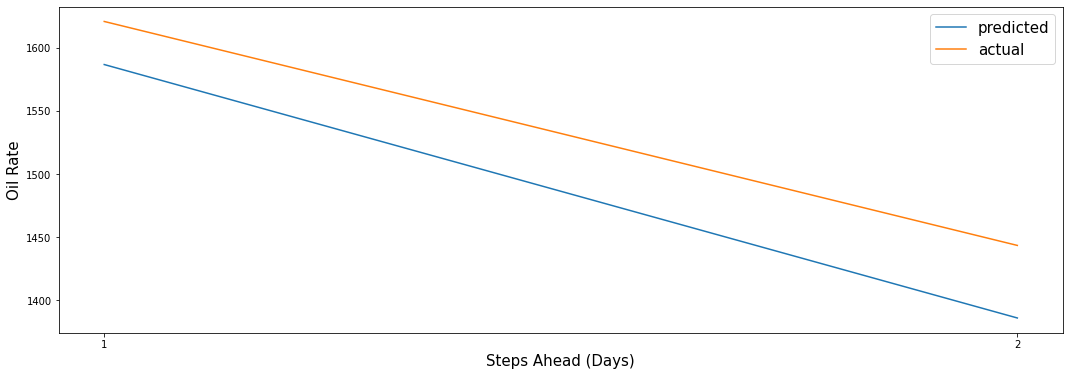

In [ ]:
# plot the last forecasted values on test set
fig, ax = plt.subplots(1, 1, figsize=(18,6)) 
# Set the major locator for the x-axis
x = list(range(1, len(inv_yhat[-1])+1))
ax.xaxis.set_major_locator(plt.MultipleLocator(1))
ax.plot(x, inv_yhat[-1], label = "predicted")
ax.plot(x, inv_y[-1], label = "actual")
ax.set_ylabel('Oil Rate', fontsize=15)
ax.set_xlabel('Steps Ahead (Days)',fontsize=15)
plt.legend(fontsize=15)
plt.show()